In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

In [11]:
df = pd.read_parquet("../data/processed/ENEFIT_dataset.parquet")
df['hour'] = df.index.hour
df['month'] = df.index.month
df['day'] = df.index.weekday + 1
df['production_target'] = df['installed_capacity'] * df['direct_solar_radiation'] / (df['temperature'] + 273.15)

In [12]:
def split_series(df, n_past, n_future, target_column_name, feature_column_names):
    """
    Split a DataFrame into past features and future target arrays.

    Parameters:
    - df: DataFrame containing the time series data.
    - n_past: Number of past observations to use for predicting the future.
    - n_future: Number of future observations to predict.
    - target_column_name: Name of the target column.
    - feature_column_names: List of column names to be used as features.
    - scaling: if dataset is scaled REMOVED

    Returns:
    - X: Array of past observations' features.
    - y: Array of future observations' target values.
    Only if scaling is true:
    - feature_scaler: scaler for X REMOVED
    - target_scaler: scaler for y REMOVED
    """

    # if scaling == 1:
    #     feature_scaler = MinMaxScaler()
    #     target_scaler = MinMaxScaler()
        
    #     # Fit the scalers
    #     feature_scaler.fit(df[feature_column_names])
    #     target_scaler.fit(df[[target_column_name]])
        
    #     # Apply the transformations
    #     scaled_features = feature_scaler.transform(df[feature_column_names])
    #     scaled_target = target_scaler.transform(df[[target_column_name]])

    X, y = list(), list()
    for window_start in range(len(df)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(df):
            break
        # Select the columns by name for the past and future segments
        # if scaling == 1:
        #     past = scaled_features[window_start:past_end]
        #     future = scaled_target[past_end:future_end]
        past = df.iloc[window_start:past_end][feature_column_names].values
        future = df.iloc[past_end:future_end][target_column_name].values
        X.append(past)
        y.append(future)
    X, y = np.array(X), np.array(y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    # if scaling == 1:
    #     return X, y, feature_scaler, target_scaler
    return X, y

def reformat_predictions_actual(pred, org_X_train):
       '''
       Converts the diff predictions into the original values, returns actual predictions and original values
       y_train[1:,:] + org_y_train[0:-1,:] == org_y_train[1]
       '''
       final_predictions = np.zeros_like(pred)

       for i in range(pred.shape[0]):
              final_predictions[i, 0] = org_X_train[i,-1] + pred[i,0]
              for j in range(1, pred.shape[1]):
                     final_predictions[i, j] = final_predictions[i, j-1] + pred[i, j]
       return final_predictions

## DEMAND FORECAST

In [13]:

n_past = 24
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
feature_column_names = train_df.drop(columns=['is_business', 'product_type_0', 'product_type_1', 'product_type_2',
       'product_type_3','target', 'supply', 'diff_supply', 'demand','lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh']).columns
# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])
scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

ARIMA_X_train, ARIMA_y_train = split_series(train_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,n_past, n_future, target_column_name, target_column_name)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (12116, 48, 33), y shape: (12116, 24)
X shape: (1452, 48, 33), y shape: (1452, 24)
X shape: (1453, 48, 33), y shape: (1453, 24)
X shape: (12116, 48, 33), y shape: (12116, 24)
X shape: (1452, 48, 33), y shape: (1452, 24)
X shape: (1453, 48, 33), y shape: (1453, 24)
X shape: (12116, 48), y shape: (12116, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)
X shape: (12116, 48), y shape: (12116, 24)
X shape: (1452, 48), y shape: (1452, 24)
X shape: (1453, 48), y shape: (1453, 24)


### ARIMA

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

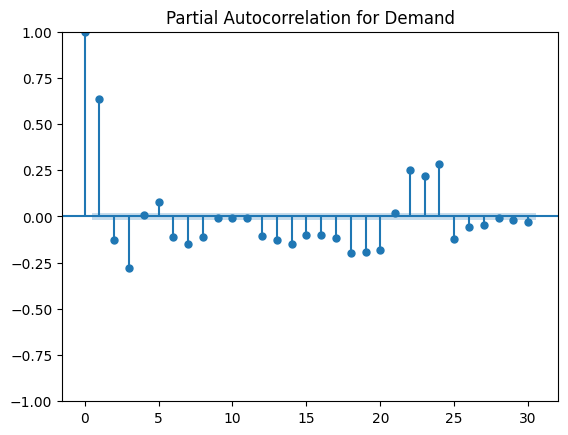

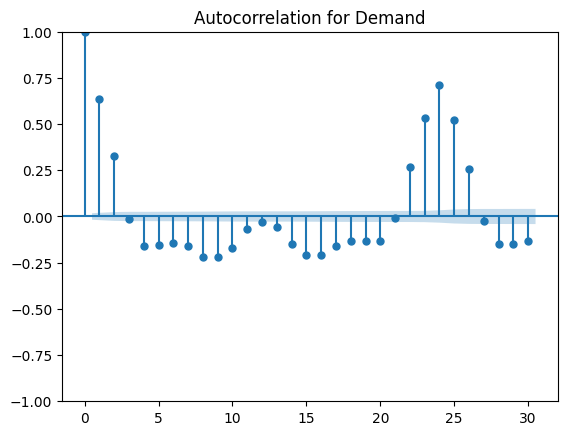

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF for p
plot_pacf(train_df[target_column_name], lags=30)
plt.title("Partial Autocorrelation for Demand")
plt.show()

# ACF for q
plot_acf(train_df[target_column_name], lags=30)
plt.title("Autocorrelation for Demand")
plt.show()


In [12]:
model = auto_arima(train_df[target_column_name], start_p=0, start_q=0,
                            test='adf',       
                            max_p=10, max_q=10, 
                            m=1,              
                            d=None,           
                            seasonal=False,   
                            start_P=0, 
                            D=0, 
                            trace=False,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(model.summary())

#Note: auto_arima uses a SARIMAX, but because I don't add any exogenous variables and seasonality is false, it is still an ARIMA model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                12187
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -106580.235
Date:                Fri, 15 Mar 2024   AIC                         213170.471
Time:                        12:05:43   BIC                         213207.511
Sample:                             0   HQIC                        213182.886
                              - 12187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7622      0.018     41.855      0.000       0.727       0.798
ar.L2         -0.4045      0.016    -25.450      0.000      -0.436      -0.373
ma.L1         -0.0781      0.018     -4.339      0.0

In [24]:
from tqdm import tqdm

def train_predict_ARIMA(train, steps, model):
    forecast = []
    forecast.append(model.predict(n_periods=steps))
    for i in tqdm(range(1, train.shape[0])):
        model.update(train[i-1,-1])
        forecast.append(model.predict(n_periods=steps))
    return np.array(forecast), model

In [25]:
# train_forecast, model = train_predict_ARIMA(ARIMA_X_train, 24, None)
val_pred, model = train_predict_ARIMA(ARIMA_X_val, 24, model)
test_pred, model = train_predict_ARIMA(ARIMA_X_test, 24, model)

100%|██████████| 1452/1452 [15:54<00:00,  1.52it/s]


In [48]:
arima_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
arima_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

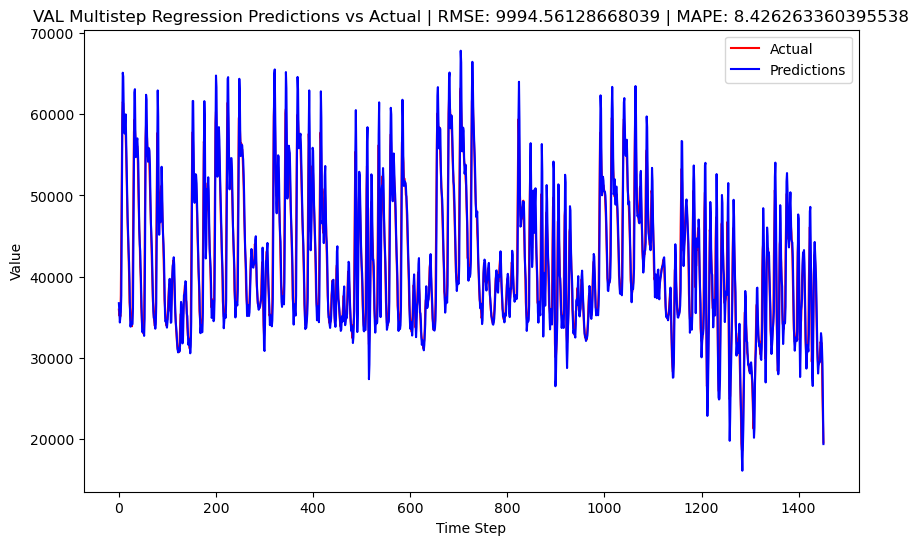

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(arima_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_val, arima_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, arima_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

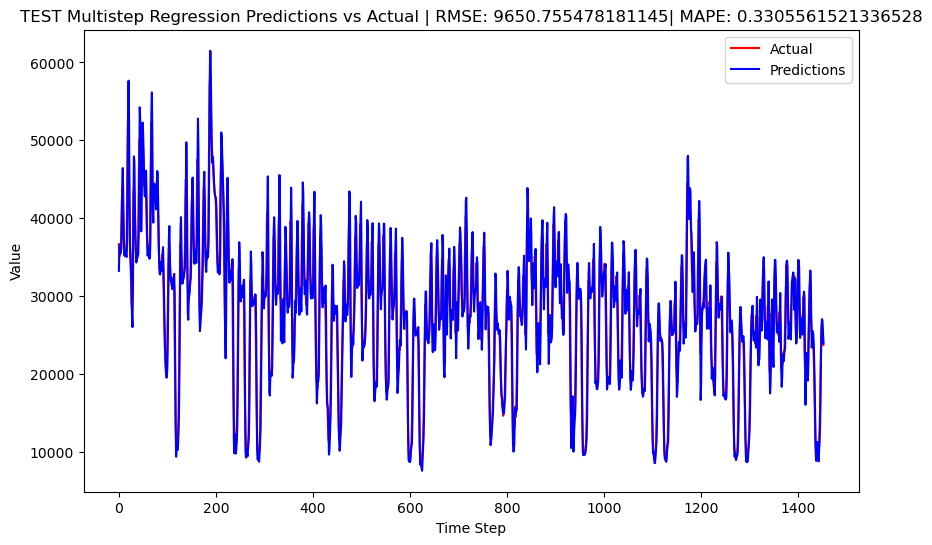

In [55]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_test[:,0], label='Actual', color='red')
plt.plot(arima_y_test_pred[:,0], label='Predictions', color='blue')

plt.title(f'TEST Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_test, arima_y_test_pred))}| MAPE: {mean_absolute_percentage_error(org_y_test+1, arima_y_test_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [56]:
arima_results = {"train": None, "val": val_pred, "test": test_pred, "formatted_train": None, "formatted_val":arima_y_val_pred, "formatted_test": arima_y_test_pred}

### XGBOOST

In [14]:
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 11],
    'colsample_bytree': [0.7, 0.9],
    'eta': [0.05, 0.1, 0.2]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_flat, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

In [16]:
xgbmodel = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    colsample_bytree=best_params['colsample_bytree'],
    enable_categorical=True,
    early_stopping_rounds = 5,
    eta = best_params['eta']
)
xgbmodel.fit(X_train_flat, y_train, eval_set=[(X_train_flat, y_train),(X_val_flat, y_val)])

KeyboardInterrupt: 

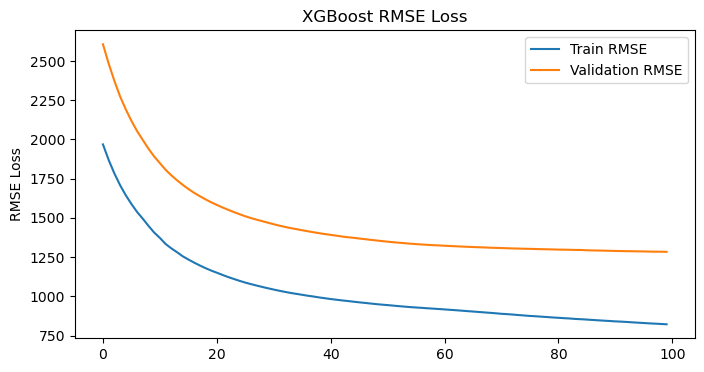

In [45]:
results = xgbmodel.evals_result()
train_mae, val_mae = results["validation_0"]["rmse"], results["validation_1"]["rmse"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train RMSE")
ax.plot(x_values, val_mae, label="Validation RMSE")
ax.legend()
plt.ylabel("RMSE Loss")
plt.title("XGBoost RMSE Loss")
plt.show()

In [49]:
train_pred = xgbmodel.predict(X_train_flat)
val_pred = xgbmodel.predict(X_val_flat)
test_pred = xgbmodel.predict(X_test_flat)

xg_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
xg_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
xg_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

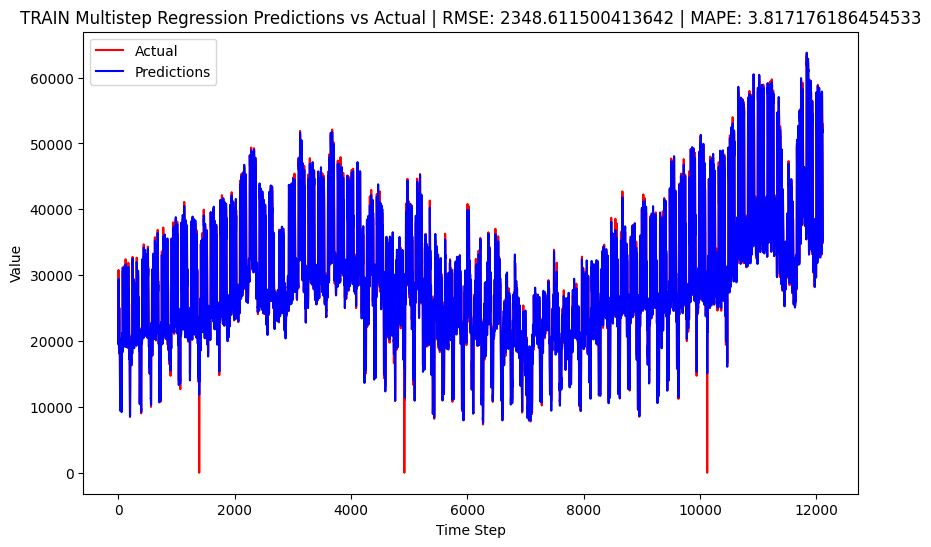

In [243]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_train[:,0], label='Actual', color='red')
plt.plot(xg_y_train_pred[:,0], label='Predictions', color='blue')

plt.title(f'TRAIN Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_train, xg_y_train_pred))} | MAPE: {mean_absolute_percentage_error(org_y_train+1, xg_y_train_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

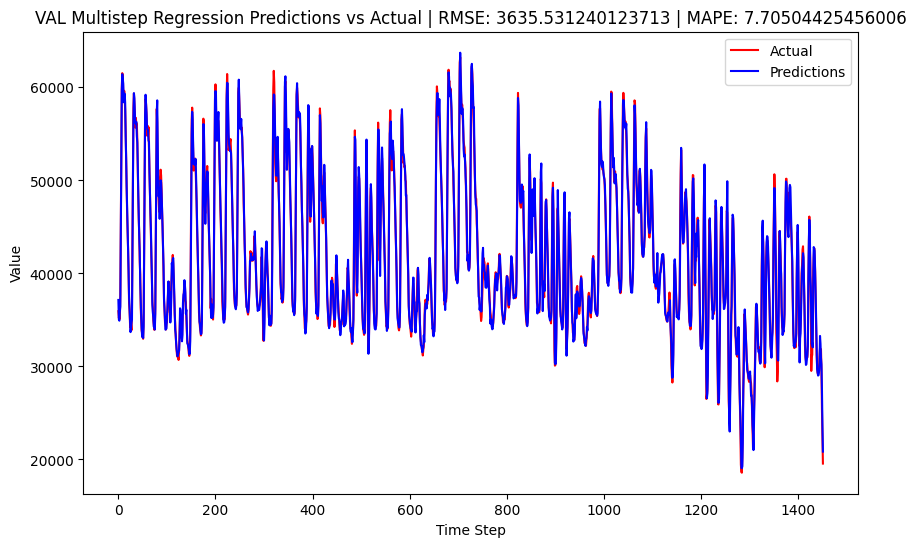

In [239]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(xg_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_val, xg_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, xg_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

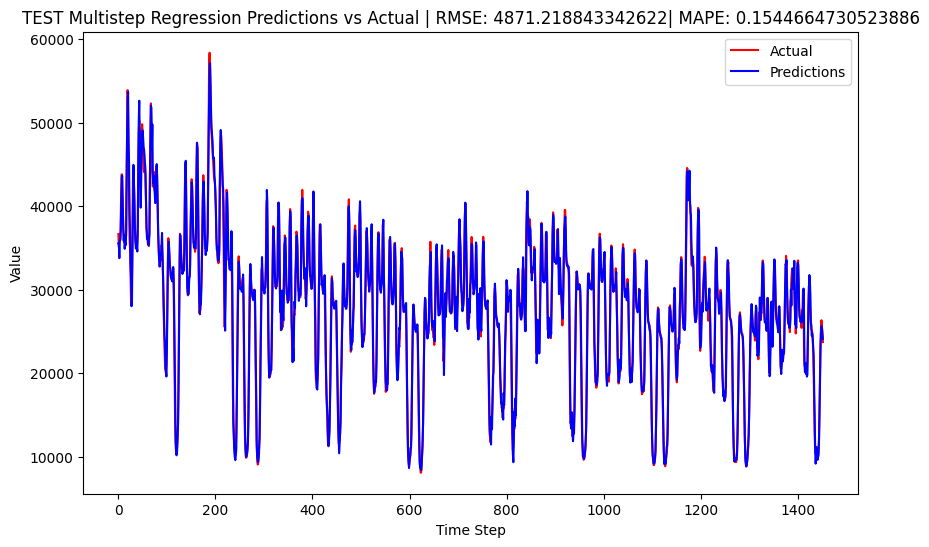

In [244]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_test[:,0], label='Actual', color='red')
plt.plot(xg_y_test_pred[:,0], label='Predictions', color='blue')

plt.title(f'TEST Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_test, xg_y_test_pred))}| MAPE: {mean_absolute_percentage_error(org_y_test+1, xg_y_test_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
xg_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": xg_y_train_pred, "formatted_val":xg_y_val_pred, "formatted_test": xg_y_test_pred}

### CNN-LSTM

In [19]:
import tensorflow as tf
from keras.layers import Bidirectional, Dense, Conv1D,MaxPooling1D, Dropout, LSTM, ReLU, Flatten, TimeDistributed, RepeatVector, LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflokeras.callbacks import EarlyStopping

def build_lstm_model(X, y):
    tf.random.set_seed(22)
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add((Conv1D(filters=64, kernel_size=3, padding='valid', input_shape= (X.shape[1],X.shape[2]))))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=32, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=16, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Dropout(0.25))

    cnn_lstm_model.add(Flatten())

    cnn_lstm_model.add(RepeatVector(y.shape[1]))

    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(y.shape[1]))
    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)


In [20]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 46, 64)            3712      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 21, 32)            6176      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 16)             1552      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 4, 16)            

In [24]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=100, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100
166/166 [==============================] - 63s 379ms/step - loss: 0.0141 - val_loss: 0.0289
Epoch 2/100
166/166 [==============================] - 63s 379ms/step - loss: 0.0125 - val_loss: 0.0231
Epoch 3/100
166/166 [==============================] - 63s 379ms/step - loss: 0.0108 - val_loss: 0.0197
Epoch 4/100
166/166 [==============================] - 61s 366ms/step - loss: 0.0090 - val_loss: 0.0105
Epoch 5/100
166/166 [==============================] - 58s 347ms/step - loss: 0.0076 - val_loss: 0.0101
Epoch 6/100
166/166 [==============================] - 57s 345ms/step - loss: 0.0068 - val_loss: 0.0122
Epoch 7/100
166/166 [==============================] - 58s 351ms/step - loss: 0.0060 - val_loss: 0.0098
Epoch 8/100
166/166 [==============================] - 61s 367ms/step - loss: 0.0054 - val_loss: 0.0089
Epoch 9/100
166/166 [==============================] - 65s 392ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 10/100
166/166 [==============================] - 61s 366m

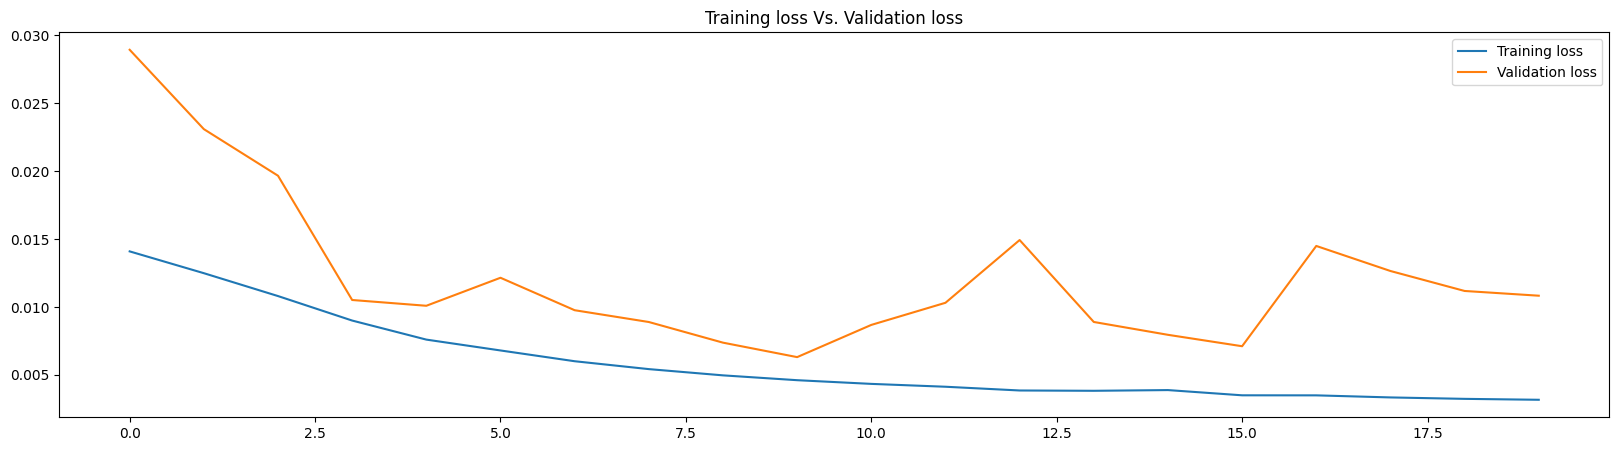

In [25]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [31]:
train_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape))
val_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape))
test_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape))
nn_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
nn_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
nn_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

70/70 [==============================] - 24s 335ms/step


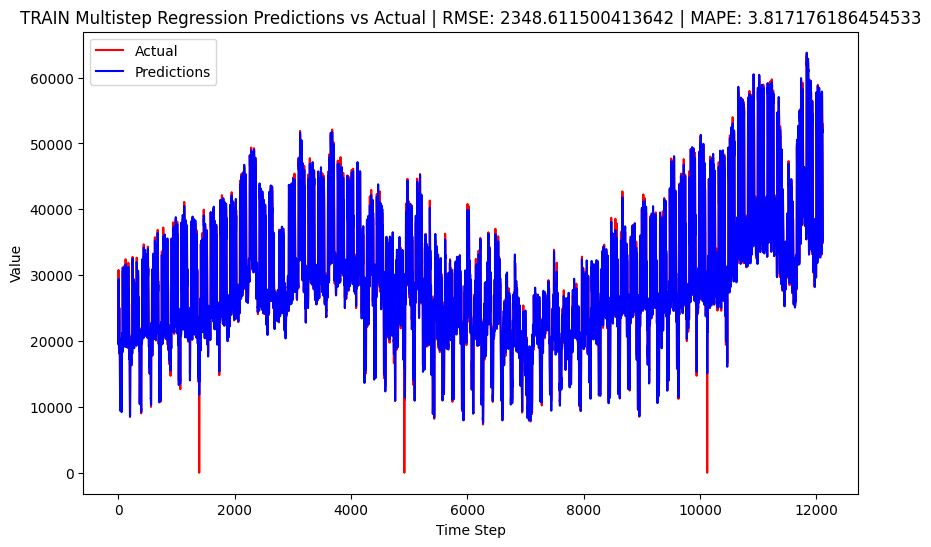

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_train[:,0], label='Actual', color='red')
plt.plot(nn_y_train_pred[:,0], label='Predictions', color='blue')

plt.title(f'TRAIN Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_train, rf_y_train_pred))} | MAPE: {mean_absolute_percentage_error(org_y_train+1, rf_y_train_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

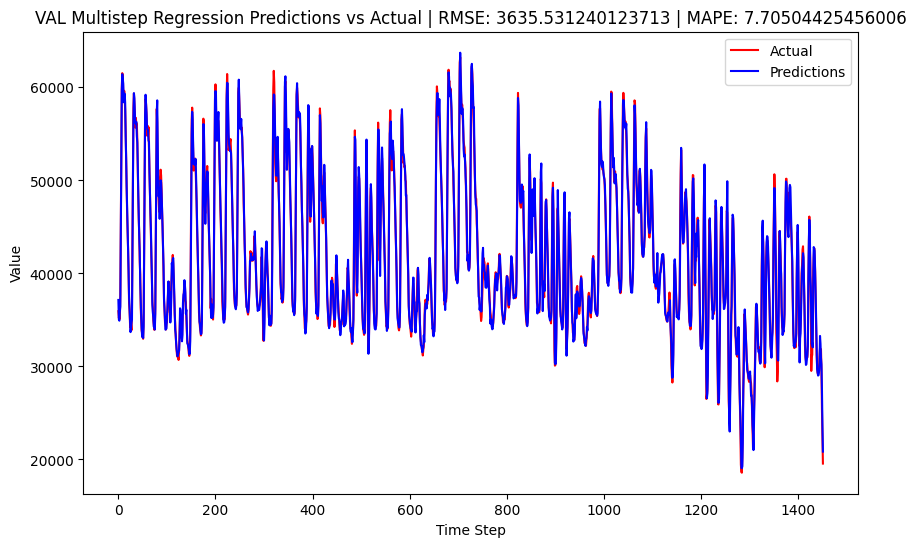

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(nn_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_val, rf_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, rf_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

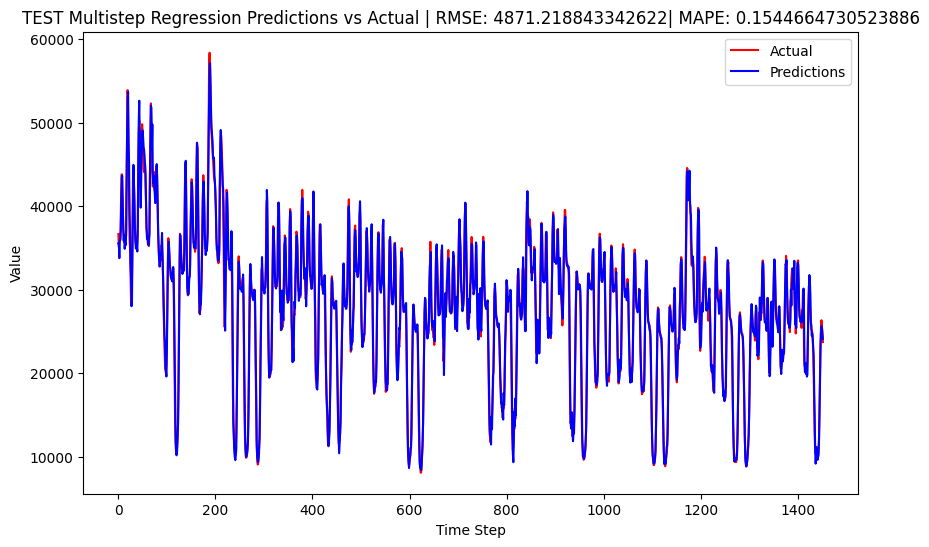

In [ ]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_test[:,0], label='Actual', color='red')
plt.plot(rf_y_test_pred[:,0], label='Predictions', color='blue')

plt.title(f'TEST Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_test,rf_y_test_pred))}| MAPE: {mean_absolute_percentage_error(org_y_test+1, rf_y_test_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
nn_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": nn_y_train_pred, "formatted_val":nn_y_val_pred, "formatted_test": nn_y_test_pred}

### SAVING PREDICTIONS

In [ ]:
demand_predictions = {"ARIMA": arima_results, "XG": xg_results, "nn": nn_results}

In [ ]:
import json 

with open("demand_predictions.json", "w") as outfile: 
    json.dump(demand_predictions, outfile)

## SOLAR FORECAST

In [183]:
n_past = 48
n_future = 24
target_column_name = 'supply'
train_df, val_df, test_df = df[1:int(len(df)*0.7)], df[int(len(df)*0.7):int(len(df)*0.7)+int(len(df)*0.15)], df[int(len(df)*0.7)+int(len(df)*0.15):] 
feature_column_names = train_df.drop(columns=['is_business', 'product_type_0', 'product_type_1', 'product_type_2',
       'product_type_3','target', 'demand','temperature', 'dewpoint', 'rain',
       'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh']).columns
# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])
scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

_, net_y_test = split_series(test_df,n_past, n_future, 'target', feature_column_names)

X shape: (10593, 48, 19), y shape: (10593, 24)
X shape: (2214, 48, 19), y shape: (2214, 24)
X shape: (2215, 48, 19), y shape: (2215, 24)
X shape: (10593, 48, 19), y shape: (10593, 24)
X shape: (2214, 48, 19), y shape: (2214, 24)
X shape: (2215, 48, 19), y shape: (2215, 24)
X shape: (2215, 48, 19), y shape: (2215, 24)


### ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

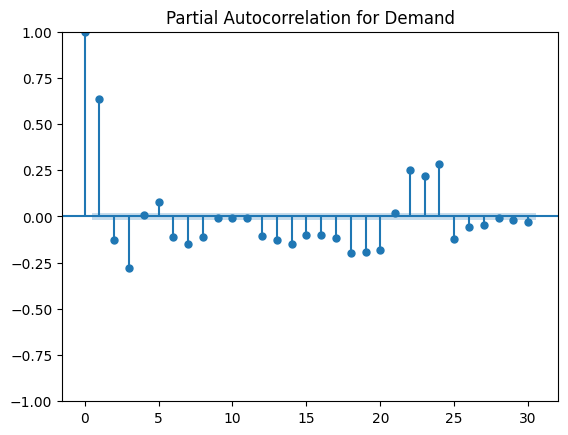

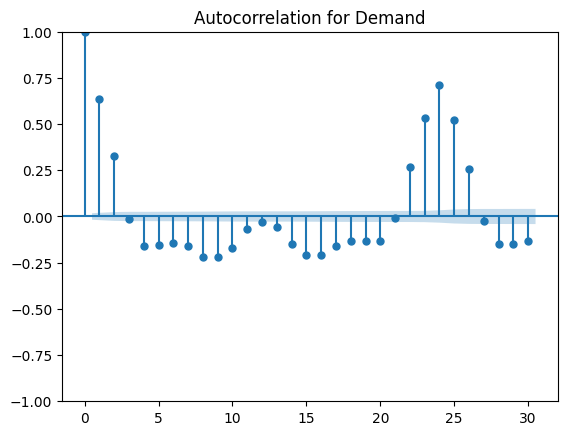

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF for p
plot_pacf(train_df[target_column_name], lags=30)
plt.title("Partial Autocorrelation for Solar")
plt.show()

# ACF for q
plot_acf(train_df[target_column_name], lags=30)
plt.title("Autocorrelation for Solar")
plt.show()


In [ ]:
model = auto_arima(train_df[target_column_name], start_p=0, start_q=0,
                            test='adf',       
                            max_p=10, max_q=10, 
                            m=1,              
                            d=None,           
                            seasonal=False,   
                            start_P=0, 
                            D=0, 
                            trace=False,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(model.summary())

#Note: auto_arima uses a SARIMAX, but because I don't add any exogenous variables and seasonality is false, it is still an ARIMA model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                12187
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -106580.235
Date:                Fri, 15 Mar 2024   AIC                         213170.471
Time:                        12:05:43   BIC                         213207.511
Sample:                             0   HQIC                        213182.886
                              - 12187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7622      0.018     41.855      0.000       0.727       0.798
ar.L2         -0.4045      0.016    -25.450      0.000      -0.436      -0.373
ma.L1         -0.0781      0.018     -4.339      0.0

In [ ]:
from tqdm import tqdm

def train_predict_ARIMA(train, steps, model):
    forecast = []
    forecast.append(model.predict(n_periods=steps))
    for i in tqdm(range(1, train.shape[0])):
        model.update(train[i-1,-1])
        forecast.append(model.predict(n_periods=steps))
    return np.array(forecast), model

In [ ]:
# train_forecast, model = train_predict_ARIMA(ARIMA_X_train, 24, None)
val_pred, model = train_predict_ARIMA(ARIMA_X_val, 24, model)
test_pred, model = train_predict_ARIMA(ARIMA_X_test, 24, model)

100%|██████████| 1452/1452 [15:54<00:00,  1.52it/s]


In [ ]:
arima_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
arima_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

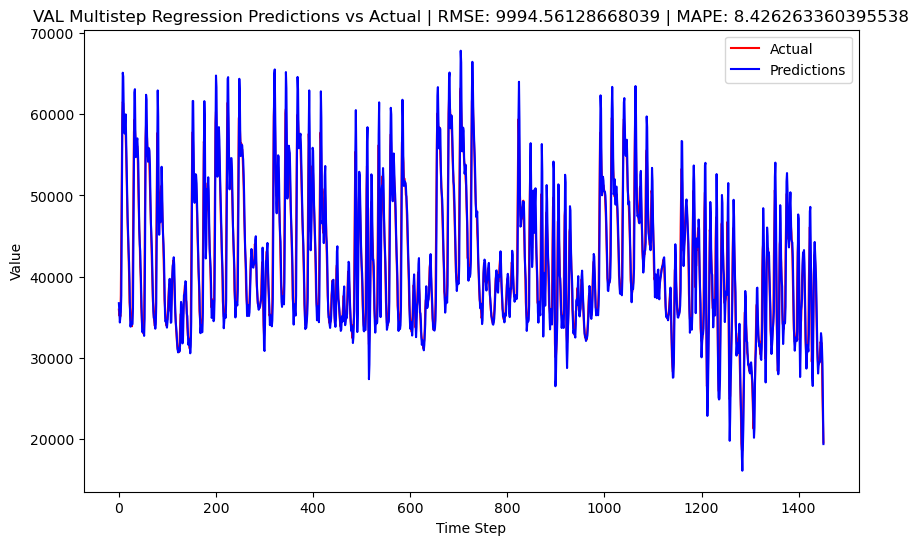

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(arima_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_val, arima_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, arima_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

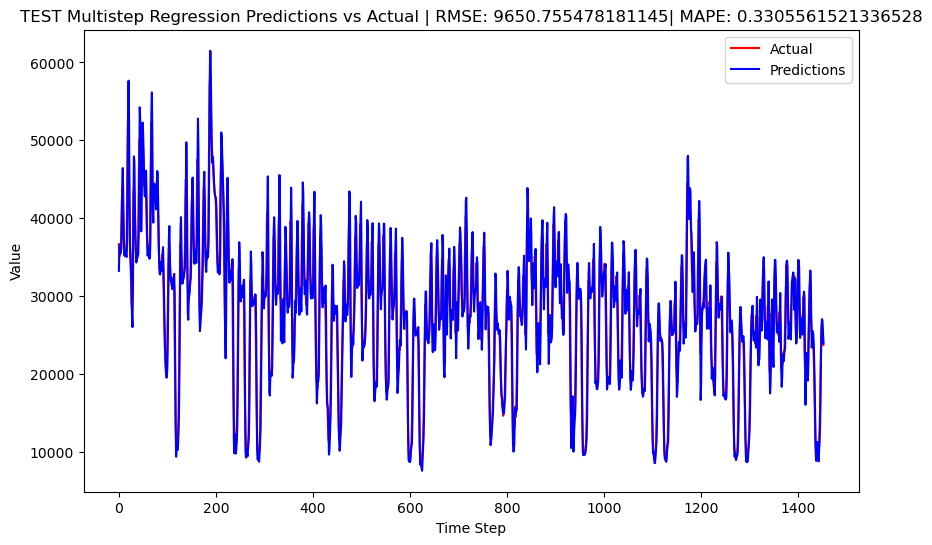

In [ ]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_test[:,0], label='Actual', color='red')
plt.plot(arima_y_test_pred[:,0], label='Predictions', color='blue')

plt.title(f'TEST Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_test, arima_y_test_pred))}| MAPE: {mean_absolute_percentage_error(org_y_test+1, arima_y_test_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
arima_results = {"train": None, "val": val_pred, "test": test_pred, "formatted_train": None, "formatted_val":arima_y_val_pred, "formatted_test": arima_y_test_pred}

### XGBOOST TO DO: CHANGE GRIDSEARCH TO BAYESIAN OPTIMIZATION

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 11],
    'colsample_bytree': [0.7, 0.9],
    'eta': [0.05, 0.1, 0.2]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_flat, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

In [ ]:
xgbmodel = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    colsample_bytree=best_params['colsample_bytree'],
    enable_categorical=True,
    early_stopping_rounds = 5,
    eta = best_params['eta']
)
xgbmodel.fit(X_train_flat, y_train, eval_set=[(X_train_flat, y_train),(X_val_flat, y_val)])

KeyboardInterrupt: 

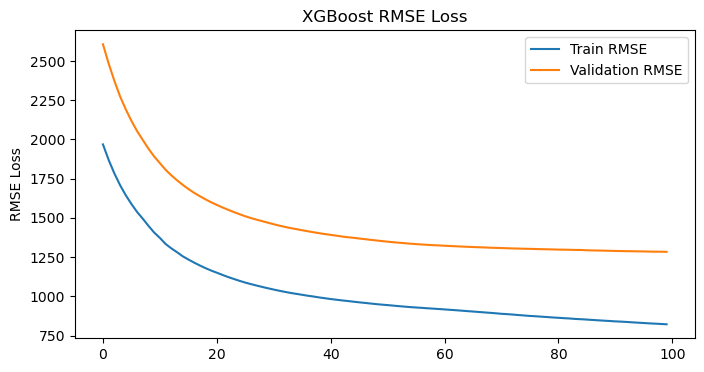

In [ ]:
results = xgbmodel.evals_result()
train_mae, val_mae = results["validation_0"]["rmse"], results["validation_1"]["rmse"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train RMSE")
ax.plot(x_values, val_mae, label="Validation RMSE")
ax.legend()
plt.ylabel("RMSE Loss")
plt.title("XGBoost RMSE Loss")
plt.show()

In [ ]:
train_pred = xgbmodel.predict(X_train_flat)
val_pred = xgbmodel.predict(X_val_flat)
test_pred = xgbmodel.predict(X_test_flat)

xg_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
xg_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
xg_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

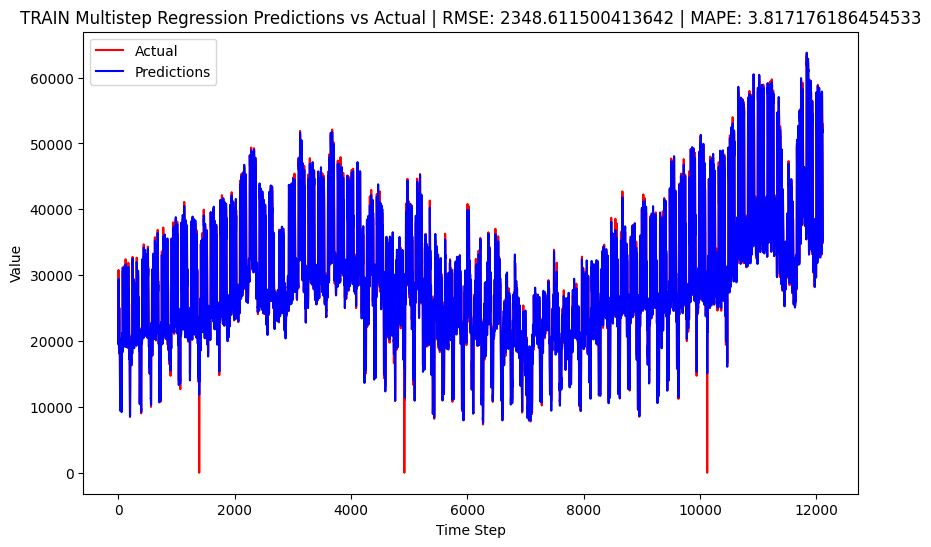

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_train[:,0], label='Actual', color='red')
plt.plot(xg_y_train_pred[:,0], label='Predictions', color='blue')

plt.title(f'TRAIN Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_train, xg_y_train_pred))} | MAPE: {mean_absolute_percentage_error(org_y_train+1, xg_y_train_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

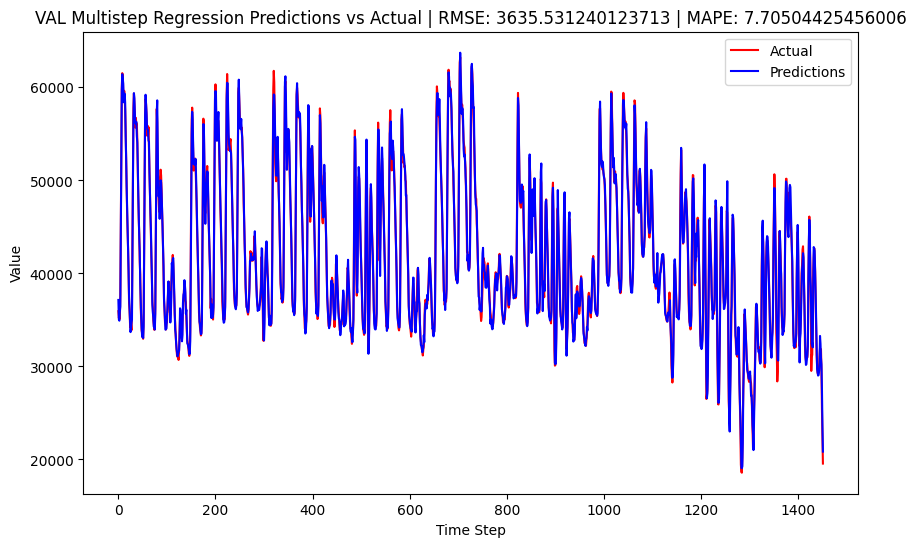

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(xg_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_val, xg_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, xg_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

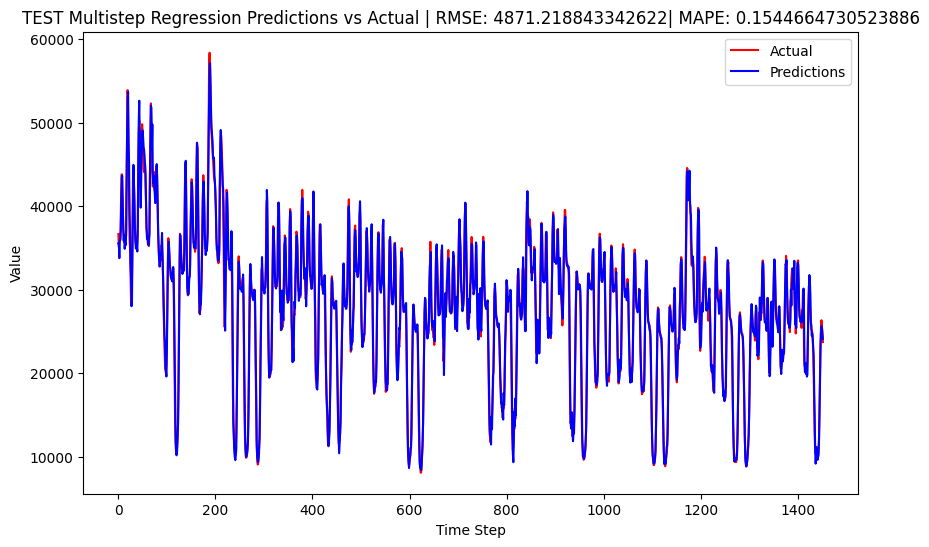

In [ ]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_test[:,0], label='Actual', color='red')
plt.plot(xg_y_test_pred[:,0], label='Predictions', color='blue')

plt.title(f'TEST Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_test, xg_y_test_pred))}| MAPE: {mean_absolute_percentage_error(org_y_test+1, xg_y_test_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
xg_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": xg_y_train_pred, "formatted_val":xg_y_val_pred, "formatted_test": xg_y_test_pred}

### CNN-LSTM

In [ ]:
import tensorflow as tf
from keras.layers import Bidirectional, Dense, Conv1D,MaxPooling1D, Dropout, LSTM, ReLU, Flatten, TimeDistributed, RepeatVector, LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflokeras.callbacks import EarlyStopping

def build_lstm_model(X, y):
    tf.random.set_seed(22)
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add((Conv1D(filters=64, kernel_size=3, padding='valid', input_shape= (X.shape[1],X.shape[2]))))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=32, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=16, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Dropout(0.25))

    cnn_lstm_model.add(Flatten())

    cnn_lstm_model.add(RepeatVector(y.shape[1]))

    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(y.shape[1]))
    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)


In [ ]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 46, 64)            3712      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 21, 32)            6176      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 16)             1552      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 4, 16)            

In [ ]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=100, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100
166/166 [==============================] - 63s 379ms/step - loss: 0.0141 - val_loss: 0.0289
Epoch 2/100
166/166 [==============================] - 63s 379ms/step - loss: 0.0125 - val_loss: 0.0231
Epoch 3/100
166/166 [==============================] - 63s 379ms/step - loss: 0.0108 - val_loss: 0.0197
Epoch 4/100
166/166 [==============================] - 61s 366ms/step - loss: 0.0090 - val_loss: 0.0105
Epoch 5/100
166/166 [==============================] - 58s 347ms/step - loss: 0.0076 - val_loss: 0.0101
Epoch 6/100
166/166 [==============================] - 57s 345ms/step - loss: 0.0068 - val_loss: 0.0122
Epoch 7/100
166/166 [==============================] - 58s 351ms/step - loss: 0.0060 - val_loss: 0.0098
Epoch 8/100
166/166 [==============================] - 61s 367ms/step - loss: 0.0054 - val_loss: 0.0089
Epoch 9/100
166/166 [==============================] - 65s 392ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 10/100
166/166 [==============================] - 61s 366m

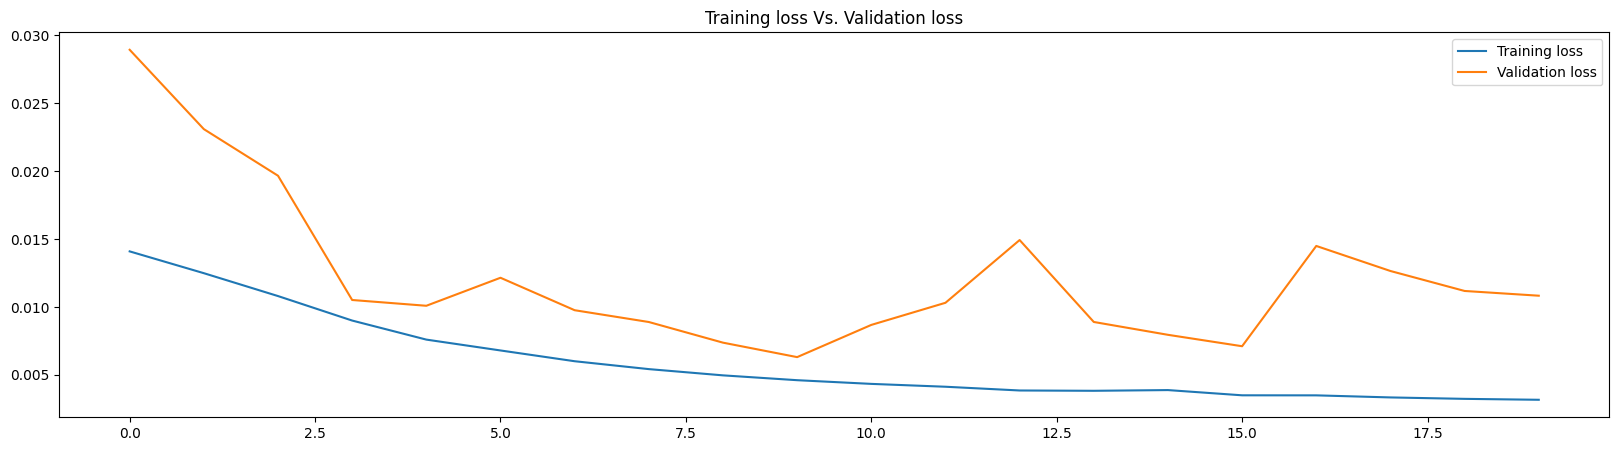

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [ ]:
train_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape))
val_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape))
test_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape))
nn_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
nn_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
nn_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

70/70 [==============================] - 24s 335ms/step


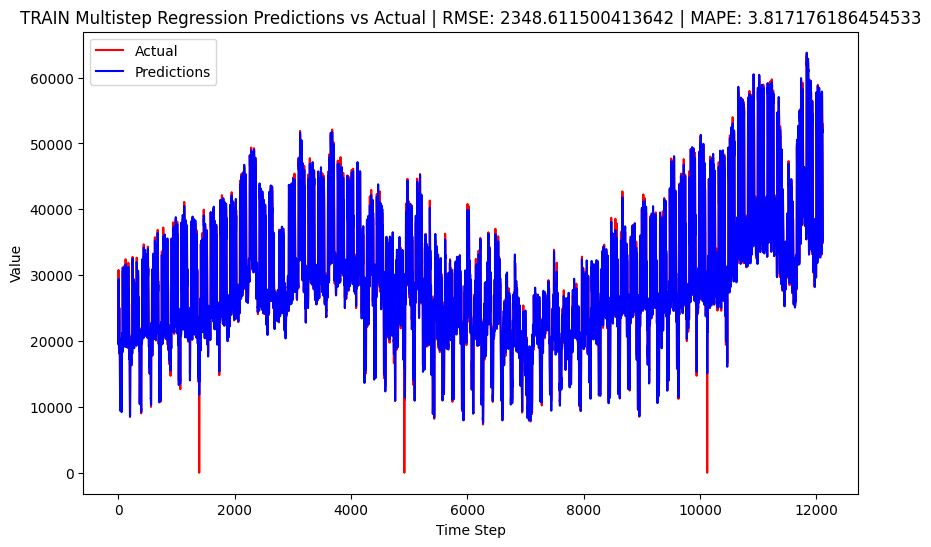

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_train[:,0], label='Actual', color='red')
plt.plot(nn_y_train_pred[:,0], label='Predictions', color='blue')

plt.title(f'TRAIN Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_train, rf_y_train_pred))} | MAPE: {mean_absolute_percentage_error(org_y_train+1, rf_y_train_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

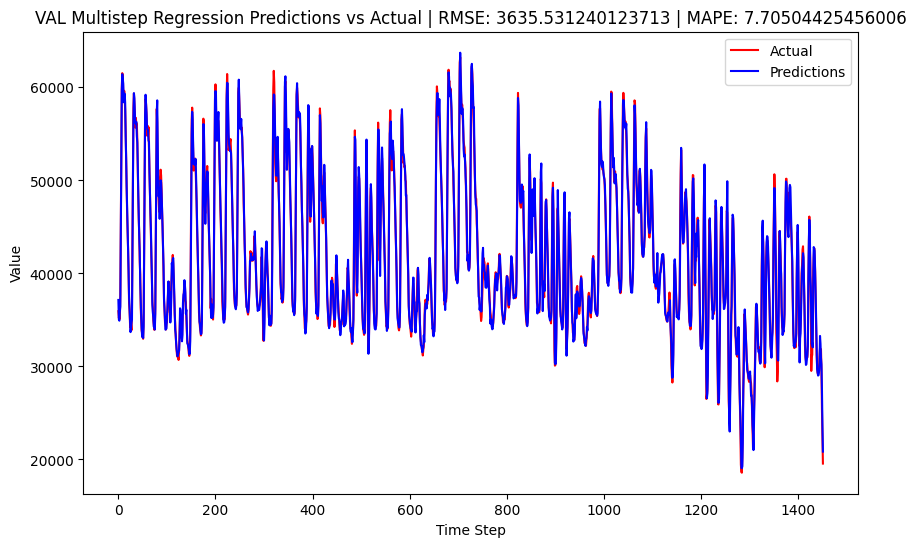

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(org_y_val[:,0], label='Actual', color='red')
plt.plot(nn_y_val_pred[:,0], label='Predictions', color='blue')

plt.title(f'VAL Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_val, rf_y_val_pred))} | MAPE: {mean_absolute_percentage_error(org_y_val+1, rf_y_val_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

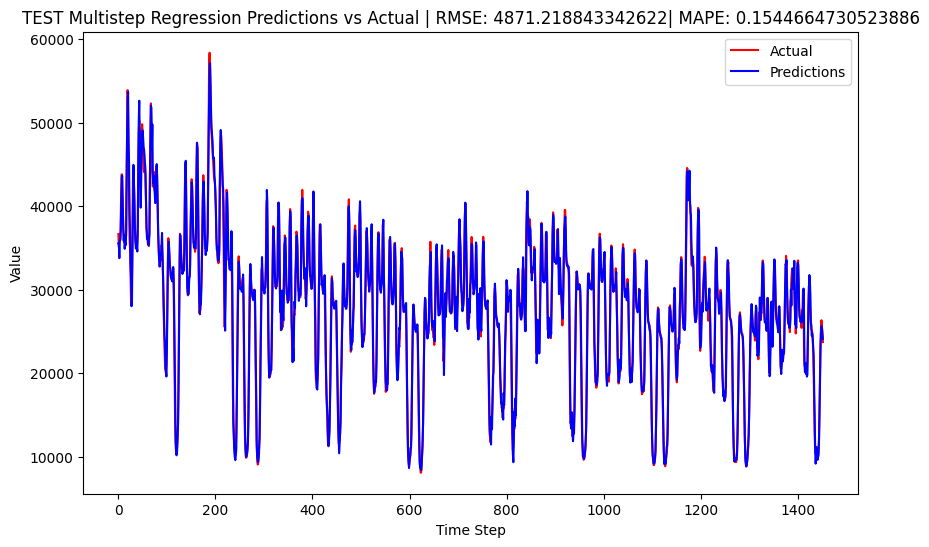

In [ ]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10, 6))
plt.plot(org_y_test[:,0], label='Actual', color='red')
plt.plot(rf_y_test_pred[:,0], label='Predictions', color='blue')

plt.title(f'TEST Multistep Regression Predictions vs Actual | RMSE: {np.sqrt(mean_squared_error(org_y_test,rf_y_test_pred))}| MAPE: {mean_absolute_percentage_error(org_y_test+1, rf_y_test_pred+1)}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
nn_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": nn_y_train_pred, "formatted_val":nn_y_val_pred, "formatted_test": nn_y_test_pred}

### SAVING PREDICTIONS

In [ ]:
solar_predictions = {"ARIMA": arima_results, "XG": xg_results, "nn": nn_results}

In [ ]:
import json 

with open("solar_predictions.json", "w") as outfile: 
    json.dump(solar_predictions, outfile)